# Assignment 1

## - Credit lending problem with logistic regression and its variants

### Due Date: Week 4

## Assignment Overview

* The goal of this assignment is to take a step-by-step approach to solving the credit lending problem on a more realistic data set. 

* In this assignment, we will start from the ETL (Extract, Transform, Load) and data cleaning, followed by building logistic models, and finally, how to produce a credit decision rule. We will also explore variants of the logistic regression
* A dataset containing the full loan data has been uploaded on Canvas. 
* Please answer the questions and write the code/results in the blanks/empty cells. 
* 27 pts in total

In [252]:
# Data analysis
import pandas as pd
import numpy as np
import seaborn as sns


# Data visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Part 1. Data pre-processing 

<a id="Section_1.1"></a>
### 1.1 Load the data 
* Read data by pandas and name it as "loans". This step has been done for you.

In [253]:
# Read data by pandas and name it as "loans". This step has been done for you.

loans = pd.read_csv('lendingclub_full_data_set_no_id.csv')
loans.head(n=10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,16000,60 months,12.74,361.93,C,C1,Aircraft Maintenance Technician,1 year,MORTGAGE,80000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25000,60 months,28.69,788.84,F,F1,Checker,5 years,MORTGAGE,75200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5000,36 months,5.32,150.58,A,A1,Principal,8 years,RENT,95000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30000,60 months,16.24,733.38,C,C5,Production Supervisor,10+ years,MORTGAGE,72900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7500,36 months,14.49,258.13,C,C4,Director Supplier Management,10+ years,MORTGAGE,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20000,60 months,12.79,452.92,C,C1,General Manager,4 years,MORTGAGE,80000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2000,36 months,16.99,71.30,D,D1,material handler,6 years,MORTGAGE,19000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13000,36 months,11.22,426.96,B,B5,Custodian,< 1 year,RENT,61000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,16000,36 months,13.67,544.29,B,B5,RN,3 years,MORTGAGE,55000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,30000,60 months,9.16,625.09,B,B2,Registered Nurse,3 years,MORTGAGE,114000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Show how many rows and columns such dataset has.

In [254]:
# Show how many rows and columns this dataset has
print(loans.shape)


(24999, 132)


In [255]:
print("Rows: {0} \nColumns: {1}".format(*loans.shape))

Rows: 24999 
Columns: 132


<a id="Section_1.2"></a>
### 1.2 Outcome variable 
The event of interest is whether a loan ends up in default or not. The variable "*loan_status*" best describes the information. We firstly take a close look at it.
* List all the unique values of "*loan_status*" and count how many are they in the data set

In [256]:
# list all the unique values of loan status and count the volume of them
loans["loan_status"].unique()

array(['Current', 'Fully Paid', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Default'],
      dtype=object)

In [257]:
temp1 = loans.groupby("loan_status").count().iloc[:,0:1].rename(columns={"loan_amnt" : "count"})
temp1

,count
loan_status,
Charged Off,2557
Current,12063
Default,2
Does not meet the credit policy. Status:Charged Off,5
Does not meet the credit policy. Status:Fully Paid,28
Fully Paid,9733
In Grace Period,174
Late (16-30 days),101
Late (31-120 days),336


* For simplicity, let us only include the loans with status is one of the following:
 * "Fully Paid"
 * "Charged Off"
 * "Late (31-120 days)"
 * "Default"
 

<div class="alert alert-warning">
<b>Suggestion: </b> Any deletion of rows could be followed by 'reset_index' to avoid such indexing issues later in the processing.

</div>

In [258]:
# Reset the "loans" dataset by only including the rows whose "loan_status" belongs to one of the following: 
# 'Fully Paid','Late (31-120 days)','Default' and 'Charged Off'
# Suggestion: any deletion of rows could be followed by reset_index to avoid such indexing issues later in the processing
included = ['Fully Paid','Late (31-120 days)','Default','Charged Off']
filtered_loans = loans[loans['loan_status'].isin(included)].reset_index()
filtered_loans

,index,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,25000,60 months,28.69,788.84,F,F1,Checker,5 years,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,30000,60 months,16.24,733.38,C,C5,Production Supervisor,10+ years,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,7500,36 months,14.49,258.13,C,C4,Director Supplier Management,10+ years,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,13000,36 months,11.22,426.96,B,B5,Custodian,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,16000,36 months,13.67,544.29,B,B5,RN,3 years,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,24993,7200,36 months,15.88,252.71,C,C4,Einstein Bros. Bagels,5 years,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12624,24995,20000,36 months,7.62,623.23,A,A3,Exercise Training Officer,10+ years,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12625,24996,35000,36 months,11.49,1154.00,B,B5,firefighter,10+ years,OWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12626,24997,18625,36 months,18.54,678.40,E,E1,Administrator,4 years,OWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Convert loan status to binary values.

  *  Rule: A “good” loan = 1 (i.e., positive) and a “bad” loan = 0 (i.e., negative). A good loan means one that is fully paid and a bad one means otherwise.

In [259]:
loans_cleaned = filtered_loans.replace({'loan_status': {
    'Fully Paid' : 1,
    'Late (31-120 days)' : 0,
    'Default' : 0,
    'Charged Off' : 0
}}
)
loans_cleaned['loan_status']

0        1
1        0
2        1
3        1
4        1
        ..
12623    1
12624    1
12625    1
12626    0
12627    1
Name: loan_status, Length: 12628, dtype: int64

* We have finisihed the pre-processing the loan status information. List again all the unique values of "loan_status" and count the volume of them



In [260]:
# List again all the unique values of "loan_status" and count the volume of them
temp1 = loans_cleaned.groupby("loan_status").count().iloc[:,0:1].rename(columns={"loan_amnt" : "count"})
temp1

,index
loan_status,
0,2895
1,9733


<a id="Section_1.3"></a>
### 1.3 Feature Manipulation
Although as aforementioned we have 132 features, we select 26 out of them here for illustration. We may make further refinement as a further exercise of feature selection.  

In [261]:
# We consider the following pool of features
feature_pool = ['fico_range_high',
 'fico_range_low',
 'acc_now_delinq',
 'installment',
 'collections_12_mths_ex_med',
 'tax_liens',
 'verification_status',
 'revol_bal',
 'home_ownership',
 'total_acc',
 'annual_inc',
 'delinq_2yrs',
 'pub_rec_bankruptcies',
 'purpose',
 'loan_amnt',
 'open_acc',
 'revol_util',
 'sub_grade',
 'delinq_amnt',
 'chargeoff_within_12_mths',
 'inq_last_6mths',
 'pub_rec',
 'term',
 'dti',
 'int_rate',
 'addr_state']

outcome = 'loan_status'

* Reset "loans" dataset by only including the features in the pool

In [262]:
# reset "loans" dataset by only including the features in the pool

feature_pool.append(outcome)
loans_df = loans_cleaned[feature_pool]

loans_df

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,verification_status,revol_bal,home_ownership,total_acc,...,sub_grade,delinq_amnt,chargeoff_within_12_mths,inq_last_6mths,pub_rec,term,dti,int_rate,addr_state,loan_status
0,689,685,0.0,788.84,0.0,0.0,Verified,4697,MORTGAGE,23.0,...,F1,0.0,0.0,4.0,0.0,60 months,23.28,28.69,GA,1
1,719,715,0.0,733.38,0.0,0.0,Verified,7265,MORTGAGE,25.0,...,C5,0.0,0.0,2.0,0.0,60 months,13.94,16.24,IL,0
2,669,665,0.0,258.13,0.0,0.0,Not Verified,27092,MORTGAGE,27.0,...,C4,0.0,0.0,0.0,0.0,36 months,14.60,14.49,AZ,1
3,714,710,0.0,426.96,0.0,0.0,Verified,12986,RENT,17.0,...,B5,0.0,0.0,2.0,0.0,36 months,24.24,11.22,FL,1
4,739,735,0.0,544.29,0.0,0.0,Not Verified,13446,MORTGAGE,30.0,...,B5,0.0,0.0,3.0,0.0,36 months,22.22,13.67,FL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,664,660,0.0,252.71,0.0,0.0,Not Verified,3533,MORTGAGE,9.0,...,C4,0.0,0.0,1.0,0.0,36 months,5.22,15.88,IN,1
12624,714,710,0.0,623.23,0.0,0.0,Verified,13387,MORTGAGE,22.0,...,A3,0.0,0.0,0.0,0.0,36 months,14.67,7.62,OR,1
12625,689,685,0.0,1154.00,0.0,0.0,Source Verified,15014,OWN,30.0,...,B5,0.0,0.0,0.0,0.0,36 months,13.59,11.49,TX,1
12626,719,715,0.0,678.40,0.0,0.0,Source Verified,31035,OWN,19.0,...,E1,0.0,0.0,1.0,0.0,36 months,34.21,18.54,OK,0


* Identify which columns are not numerical type

In [263]:
# List the types of all fields

loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12628 entries, 0 to 12627
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   fico_range_high             12628 non-null  int64  
 1   fico_range_low              12628 non-null  int64  
 2   acc_now_delinq              12628 non-null  float64
 3   installment                 12628 non-null  float64
 4   collections_12_mths_ex_med  12627 non-null  float64
 5   tax_liens                   12627 non-null  float64
 6   verification_status         12628 non-null  object 
 7   revol_bal                   12628 non-null  int64  
 8   home_ownership              12628 non-null  object 
 9   total_acc                   12628 non-null  float64
 10  annual_inc                  12628 non-null  float64
 11  delinq_2yrs                 12628 non-null  float64
 12  pub_rec_bankruptcies        12620 non-null  float64
 13  purpose                     126

At this stage, you will find the following variables to be categorical: `home_ownership`, `term`, `sub_grade`, `addr_state`, `verification_status`, and `purpose`

* Pre-process the categorical variables by dealing with the outliers so that each value is not too rare in the data
  *  Proprocessing rules: 
     * For the variable `home_ownership`, rename the values of 'ANY and 'NONE' to 'OTHER'
     * For the variable `purpose`, rename the values of 'renewable_energy' and 'educational' to 'other'
     * For the variable `sub_grade`, rename the values of 'G1', 'G2', 'G3', 'G4', 'G5' to 'G'


In [264]:
# For all values of the 'home_ownership' variable that are 'ANY' or 'NONE', rename them to 'OTHER'
loans_df = loans_df.replace({'home_ownership' :
                            {'ANY' : 'OTHER',
                            'NONE' : 'OTHER'}
                            })

# For all values of the 'purpose' variable that are 'renewable_energy' or 'educational', rename them to 'other'
loans_df = loans_df.replace({'purpose' :
                            {'renewable_energy' : 'other',
                            'educational' : 'other'}
                            })

# For all values of the 'sub_grade' variable that are 'G1', 'G2', 'G3', 'G4', or 'G5', rename them to 'G'
loans_df = loans_df.replace({'sub_grade' :
                            {'G1' : 'G',
                             'G2' : 'G',
                             'G3' : 'G',
                             'G4' : 'G',
                             'G5' : 'G'
                            }
                            })
loans_df

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,verification_status,revol_bal,home_ownership,total_acc,...,sub_grade,delinq_amnt,chargeoff_within_12_mths,inq_last_6mths,pub_rec,term,dti,int_rate,addr_state,loan_status
0,689,685,0.0,788.84,0.0,0.0,Verified,4697,MORTGAGE,23.0,...,F1,0.0,0.0,4.0,0.0,60 months,23.28,28.69,GA,1
1,719,715,0.0,733.38,0.0,0.0,Verified,7265,MORTGAGE,25.0,...,C5,0.0,0.0,2.0,0.0,60 months,13.94,16.24,IL,0
2,669,665,0.0,258.13,0.0,0.0,Not Verified,27092,MORTGAGE,27.0,...,C4,0.0,0.0,0.0,0.0,36 months,14.60,14.49,AZ,1
3,714,710,0.0,426.96,0.0,0.0,Verified,12986,RENT,17.0,...,B5,0.0,0.0,2.0,0.0,36 months,24.24,11.22,FL,1
4,739,735,0.0,544.29,0.0,0.0,Not Verified,13446,MORTGAGE,30.0,...,B5,0.0,0.0,3.0,0.0,36 months,22.22,13.67,FL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,664,660,0.0,252.71,0.0,0.0,Not Verified,3533,MORTGAGE,9.0,...,C4,0.0,0.0,1.0,0.0,36 months,5.22,15.88,IN,1
12624,714,710,0.0,623.23,0.0,0.0,Verified,13387,MORTGAGE,22.0,...,A3,0.0,0.0,0.0,0.0,36 months,14.67,7.62,OR,1
12625,689,685,0.0,1154.00,0.0,0.0,Source Verified,15014,OWN,30.0,...,B5,0.0,0.0,0.0,0.0,36 months,13.59,11.49,TX,1
12626,719,715,0.0,678.40,0.0,0.0,Source Verified,31035,OWN,19.0,...,E1,0.0,0.0,1.0,0.0,36 months,34.21,18.54,OK,0


* Transform categorical variables into numerical values

* Rules:
 * For every categorical variable with k alternatives, please replace it with k-1 dummy variables using one-hot encoding.
 * For example, '*home_ownership*' take value from four values: '**OWN**', '**RENT**', '**NONE**', '**MORTGAGE**', and '**OTHER**'. Create four dummies for '*home_ownership*' using one-hot encoding. Then drop the column "*home_ownership*", plus one of the four dummies to avoid the **multicollinearity** issue. Finally, integrate the three dummies to dataset. 
 * For other categorical variables, you may follow a similar process. 
 * You may find the method <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">get_dummies()</a> useful to automate the process.
 


In [265]:
# For every categorical variable with k alternatives, please replace it with k-1 dummy variables using one-hot encoding.

category_pool = ['home_ownership', 'term', 'sub_grade', 'verification_status','purpose','addr_state']

loans_df = pd.get_dummies(loans_df, columns=category_pool)
loans_df

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,689,685,0.0,788.84,0.0,0.0,4697,23.0,75200.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,719,715,0.0,733.38,0.0,0.0,7265,25.0,72900.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,669,665,0.0,258.13,0.0,0.0,27092,27.0,180000.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,714,710,0.0,426.96,0.0,0.0,12986,17.0,61000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,739,735,0.0,544.29,0.0,0.0,13446,30.0,55000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,664,660,0.0,252.71,0.0,0.0,3533,9.0,101108.0,0.0,...,False,False,False,False,False,False,False,False,False,False
12624,714,710,0.0,623.23,0.0,0.0,13387,22.0,62000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
12625,689,685,0.0,1154.00,0.0,0.0,15014,30.0,90000.0,1.0,...,False,False,True,False,False,False,False,False,False,False
12626,719,715,0.0,678.40,0.0,0.0,31035,19.0,55000.0,0.0,...,False,False,False,False,False,False,False,False,False,False


Now that you have finished the transformation, 
 * Please make sure that all of them are of numerical type.
 * Also, count and print the number of features now after transformation

In [266]:
# Count the number of features now after transformation
# All fields should be of numerical types by this stage.

print(loans_df.info())
print('\n')
print('Features: ' + str(loans_df.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12628 entries, 0 to 12627
Columns: 123 entries, fico_range_high to addr_state_WY
dtypes: bool(102), float64(16), int64(5)
memory usage: 3.3 MB
None


Features: 123


* Check for missing values: count how many missing values there are in every column of the dataframe *loans*.

In [267]:
# Count how many missing values there are in every column of the dataframe loans.

loans_df.isnull().sum().sum()

20

At this stage, you will find that the only variable with missing values is `tax_liens`, `revol_util`, `dti`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths` and `pub_rec_bankruptcies`

* Fill in the missing values: 
 * First, use its **median**  fill the missing values of those fields. You may find the the method <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">DataFrame.fillna()</a> useful to automate the process.
 * Then, check again whether there are any missing values

<div class="alert alert-warning">
<b>Note: </b> When you use fillna(), be careful with <B>replace</B> parameter because you need to modify the original variable but not a review.    
</div>

In [268]:
variables_to_complete = ['tax_liens','revol_util', 'dti', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies']

# Process missing values: use the median value of each field to fill in the missing values
loans_df.fillna(loans_df.median(), inplace=True)

In [269]:
# check again whether there are any missing values
loans_df.isnull().sum().sum()

0

While we do not proceed further here, it is worth mentioning that there are further ways to "cleverly" select the features. For further read, you may find the discussion in <a href="https://scikit-learn.org/stable/modules/feature_selection.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Feature Selection</a> useful.

### 1.4 Data Splitting
* Randomly split the pre-processed loan data into training, validation and test set.
 * First, randomly shuffle the data using `np.random.RandomState(seed=42).permutation(n)`.  The random seed has been set to `seed = 42` to make sure the result is replicatable. 
   * The data shuffling has been done for you.
 * Second, assign each row to the train/validation/test set according to the following rule:
   * For rows 0-6999 (inclusive): assign them to the training set
   * For rows 7000-9999 (inclusive): assign them to the validation set
   * For the rest of the rows: assign them to the test set
  


In [270]:
# Randomly shuffle the data. This step has been done for you.
n = len(loans_df)
random_index = np.random.RandomState(seed=42).permutation(n)
loans_df = loans_df.iloc[random_index]
loans_df.reset_index(drop=True, inplace=True)

In [271]:
loans_df

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,719,715,0.0,289.14,0.0,0.0,10802,17.0,62500.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,694,690,0.0,305.31,0.0,0.0,2981,29.0,60000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,679,675,0.0,864.80,0.0,0.0,104954,32.0,135000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,689,685,0.0,566.52,0.0,0.0,5568,57.0,56000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,704,700,0.0,240.59,0.0,0.0,15185,20.0,49000.0,0.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,734,730,0.0,656.50,0.0,0.0,32101,28.0,47000.0,0.0,...,False,False,True,False,False,False,False,False,False,False
12624,674,670,0.0,229.14,0.0,0.0,3770,34.0,90000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
12625,669,665,0.0,529.07,0.0,0.0,22040,30.0,68000.0,2.0,...,False,False,True,False,False,False,False,False,False,False
12626,709,705,0.0,153.61,0.0,0.0,45968,38.0,117000.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [272]:
# Split the pre-processed loan data into training, validation and test set
# Suggestion: any deletion of rows could be followed by reset_index to avoid such indexing issues later in the processing
# y is loan_status

training_df = loans_df.iloc[0:6700,]
val_df = loans_df.iloc[6700:10000,]
test_df = loans_df.iloc[10000:,]

training_df

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,719,715,0.0,289.14,0.0,0.0,10802,17.0,62500.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,694,690,0.0,305.31,0.0,0.0,2981,29.0,60000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,679,675,0.0,864.80,0.0,0.0,104954,32.0,135000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,689,685,0.0,566.52,0.0,0.0,5568,57.0,56000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,704,700,0.0,240.59,0.0,0.0,15185,20.0,49000.0,0.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,704,700,0.0,150.20,0.0,0.0,6304,42.0,70000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
6696,664,660,0.0,655.13,0.0,1.0,5768,48.0,160000.0,0.0,...,False,False,False,False,False,False,False,False,False,False
6697,709,705,0.0,73.85,0.0,0.0,36191,19.0,40000.0,0.0,...,False,False,False,False,False,True,False,False,False,False
6698,674,670,0.0,488.53,0.0,0.0,16057,42.0,78000.0,2.0,...,False,False,False,False,False,False,False,False,False,False


### 1.5 Data re-scaling
* Scale the training, validation, and test data sets. 
 * First, further split the training, validation, and test data sets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val` and `y_test`
 * Then, scale the feature information off all three datasets based on the mean and standard deviations of the training set 
   
This step is similar to what we did in the lecture. Note that scaling is important in improving the numerical stability.

<div class="alert alert-warning">
<b>Note: </b> In later parts of this assignment, we will also be using the unscaled version of the feature data. So please keep a copy of the unscaled features using the <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">copy()</a> method. (Or, you can keep the scaling coefficients so that you can transform the scaled data back to the unscaled ones.)
</div>

In [273]:
# Remove target column to create feature only dataset: 'X_train', 'X_val', and 'X_test', respectively 

X_train = training_df.drop(columns='loan_status')

X_val = val_df.drop(columns='loan_status')

X_test = test_df.drop(columns='loan_status')

# Keep a copy of the unscaled features using the ".copy()" method, and name them 'X_train_unscale', 'X_val_unscale', and 'X_test_unscale', respectively

X_train_unscale = X_train.copy()

X_val_unscale = X_val.copy()

X_test_unscale = X_test.copy()

# Scale 'X_train', 'X_val', and 'X_test' data using the mean and standard deviation of the training set. 

sc = StandardScaler()

X_train.iloc[:,:] = sc.fit_transform(X_train.iloc[:,:])
X_val.iloc[:,:] = sc.fit_transform(X_val.iloc[:,:])
X_test.iloc[:,:] = sc.fit_transform(X_test.iloc[:,:])

# Store target column as y-variables in the following datasets: 'y_train', 'y_val', and 'y_test'

y_train = training_df['loan_status']

y_val = val_df['loan_status']

y_test = test_df['loan_status']


### 1.6  Summary
* Please print the following:
  * The first five instances for training, validation, and test data sets, respectively
  * The percentages of all outcome levels for each data set
  * The shapes of the split datasets
  * Feature names

In [274]:
# Print the first five instances for training, validation, and test data sets, respectively, as well as the percentages of all outcome levels
temp = [X_train, X_val, X_test]

for i in temp:
    display(i.head(5))

# Print the shapes of the split datasets

temp1 = ['X_train', 'X_val', 'X_test']

for i in range(len(temp)):
    print('{0} shape is: {1}'.format(temp1[i],temp[i].shape))
    
# Print the feature names

print(X_train.columns.values)

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,0.635171,0.635210,-0.068631,-0.571090,-0.120287,-0.145138,-0.265908,-0.697902,-0.244102,-0.359394,...,-0.042359,-0.127394,-0.295183,-0.095059,-0.171301,-0.048926,-0.147149,-0.10993,-0.069275,-0.050436
1,-0.165587,-0.165585,-0.068631,-0.506910,-0.120287,-0.145138,-0.665892,0.313787,-0.293374,-0.359394,...,-0.042359,-0.127394,-0.295183,-0.095059,-0.171301,-0.048926,-0.147149,-0.10993,-0.069275,-0.050436
2,-0.646042,-0.646062,-0.068631,1.713778,-0.120287,-0.145138,4.549237,0.566709,1.184784,-0.359394,...,-0.042359,-0.127394,-0.295183,-0.095059,-0.171301,-0.048926,-0.147149,-0.10993,-0.069275,-0.050436
3,-0.325739,-0.325744,-0.068631,0.529866,-0.120287,-0.145138,-0.533587,2.674394,-0.372209,-0.359394,...,-0.042359,-0.127394,-0.295183,-0.095059,-0.171301,-0.048926,-0.147149,-0.10993,-0.069275,-0.050436
4,0.154716,0.154733,-0.068631,-0.763792,-0.120287,-0.145138,-0.041752,-0.444979,-0.510171,-0.359394,...,-0.042359,-0.127394,-0.295183,-0.095059,5.837682,-0.048926,-0.147149,-0.10993,-0.069275,-0.050436


,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
6700,-0.970814,-0.970814,-0.053226,0.998659,-0.118413,-0.143413,0.178216,-0.202674,0.918161,4.403316,...,-0.049296,-0.11354,-0.314485,-0.098954,-0.174945,-0.038954,-0.164552,-0.121491,-0.046106,-0.046106
6701,-0.811940,-0.811940,-0.053226,-0.561816,-0.118413,-0.143413,-0.284831,-0.874857,-0.774260,-0.360537,...,-0.049296,-0.11354,-0.314485,-0.098954,-0.174945,-0.038954,-0.164552,-0.121491,-0.046106,-0.046106
6702,-0.970814,-0.970814,-0.053226,-0.936491,-0.118413,-0.143413,0.519111,-1.210949,0.579677,-0.360537,...,-0.049296,-0.11354,-0.314485,-0.098954,-0.174945,-0.038954,-0.164552,-0.121491,-0.046106,-0.046106
6703,1.253416,1.253416,-0.053226,2.254787,-0.118413,-0.143413,0.017326,1.225717,0.918161,-0.360537,...,-0.049296,-0.11354,3.179797,-0.098954,-0.174945,-0.038954,-0.164552,-0.121491,-0.046106,-0.046106
6704,0.141301,0.141301,-0.053226,-0.435172,-0.118413,-0.143413,-0.306886,-0.538765,-0.706563,-0.360537,...,-0.049296,-0.11354,-0.314485,-0.098954,-0.174945,-0.038954,-0.164552,-0.121491,-0.046106,-0.046106


,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
10000,3.497928,3.498143,-0.062684,0.992512,-0.112579,-0.138432,-0.290075,-0.772498,-0.389460,-0.334134,...,-0.047836,-0.114487,-0.292407,-0.087571,-0.170218,-0.039043,-0.152854,-0.105632,-0.055258,-0.04366
10001,0.476353,0.476392,-0.062684,1.766456,-0.112579,-0.138432,0.892966,-0.278049,0.461704,-0.334134,...,-0.047836,-0.114487,3.419891,-0.087571,-0.170218,-0.039043,-0.152854,-0.105632,-0.055258,-0.04366
10002,-0.318799,-0.318805,-0.062684,0.844473,-0.112579,-0.138432,0.070992,0.216400,0.461704,-0.334134,...,-0.047836,-0.114487,-0.292407,-0.087571,-0.170218,-0.039043,-0.152854,-0.105632,-0.055258,-0.04366
10003,-0.159769,-0.159766,-0.062684,-1.426968,-0.112579,-0.138432,-0.295786,-0.030825,0.537364,-0.334134,...,-0.047836,-0.114487,-0.292407,-0.087571,5.874820,-0.039043,-0.152854,-0.105632,-0.055258,-0.04366
10004,1.748595,1.748708,-0.062684,1.210178,-0.112579,-0.138432,4.765699,0.051583,-0.313801,-0.334134,...,-0.047836,-0.114487,-0.292407,-0.087571,-0.170218,-0.039043,-0.152854,-0.105632,-0.055258,-0.04366


X_train shape is: (6700, 122)
X_val shape is: (3300, 122)
X_test shape is: (2628, 122)
['fico_range_high' 'fico_range_low' 'acc_now_delinq' 'installment'
 'collections_12_mths_ex_med' 'tax_liens' 'revol_bal' 'total_acc'
 'annual_inc' 'delinq_2yrs' 'pub_rec_bankruptcies' 'loan_amnt' 'open_acc'
 'revol_util' 'delinq_amnt' 'chargeoff_within_12_mths' 'inq_last_6mths'
 'pub_rec' 'dti' 'int_rate' 'home_ownership_MORTGAGE'
 'home_ownership_OTHER' 'home_ownership_OWN' 'home_ownership_RENT'
 'term_ 36 months' 'term_ 60 months' 'sub_grade_A1' 'sub_grade_A2'
 'sub_grade_A3' 'sub_grade_A4' 'sub_grade_A5' 'sub_grade_B1'
 'sub_grade_B2' 'sub_grade_B3' 'sub_grade_B4' 'sub_grade_B5'
 'sub_grade_C1' 'sub_grade_C2' 'sub_grade_C3' 'sub_grade_C4'
 'sub_grade_C5' 'sub_grade_D1' 'sub_grade_D2' 'sub_grade_D3'
 'sub_grade_D4' 'sub_grade_D5' 'sub_grade_E1' 'sub_grade_E2'
 'sub_grade_E3' 'sub_grade_E4' 'sub_grade_E5' 'sub_grade_F1'
 'sub_grade_F2' 'sub_grade_F3' 'sub_grade_F4' 'sub_grade_F5' 'sub_grade_G'
 'ver

# Part 2. Predicting with (basic) Logistic Regression 

Let us divide this step into three stage: model training, decision criterion selection, and performance evaluation. The test data should be **only** used in the last stage. 

### 2.1 Model training
* Fit a LogisticRegression model using the training data. 
 * Please use the scikit-learn package <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Logistic Regression</a>
 * The training parameters we use are: 
   * `penalty="none"` (It means there is no regularization) 
   *  `solver="newton-cg"` (It means we use the newton-cg method to solve the MLE problem. This is a slightly more advanced algorithm than what we used in class.)
 * Print the trained coefficients

In [275]:
#Fit a LogisticRegression model using the training data
model = LogisticRegression(penalty='none', solver='newton-cg')
model.fit(X_train, y_train)

# Print the estimated coefficients

y_pred_temp = model.predict(X_val)
print(y_pred_temp)


C:\Users\Sean Law\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[1 1 1 ... 1 0 1]


### 2.2 Decision criterion

In this assignment, we will choose the decision criterion based on the validation data according to the expected payoff objective. For simplicity, let us assume that the payoff from a good loan is loan amount times multiplied by the interest rate, and the loss from a bad loan is the loan amount itself. (That is, there is no recovery from a bad loan.) 

* Please report the following quantities:
  * The average interest rate (in percentage number) in the **UNSCALED** training, validation, and test datasets
  * The average loan amount (in USD) in the **UNSCALED** training, validation, and test datasets

In [276]:
# Print the average interest rate and loan amount in the unscaled training, validation, and test datasets
# int_rate, loan_amnt

print('Average interest rate training: {}'.format(X_train_unscale['int_rate'].mean()))
print('Average interest rate validation: {}'.format(X_val_unscale['int_rate'].mean()))
print('Average interest rate test: {}'.format(X_test_unscale['int_rate'].mean()))
print('\n')
print('Average loan amount training: {}'.format(X_train_unscale['loan_amnt'].mean()))
print('Average loan amount validation: {}'.format(X_val_unscale['loan_amnt'].mean()))
print('Average loan amount test: {}'.format(X_test_unscale['loan_amnt'].mean()))


Average interest rate training: 13.525588059701493
Average interest rate validation: 13.605269696969696
Average interest rate test: 13.498044140030443


Average loan amount training: 14227.380597014926
Average loan amount validation: 14315.901515151516
Average loan amount test: 14268.635844748858


*  Write a Python function `get_EP` that calculates, for every given threshold, the expected payoff from a randomly drawn borrower based on the average interest rates/loan amounts 
    * The Python function should allow the user to specify whether to perform the calculation on validation or test data
    * Please set the profit parameter "P" to be the average interest times times the average loan amount
    * Please set the loss parameter "L" to be the average loan amount
    * You can write additional functions if needed, and use/modify the codes provided in the lecture

In [277]:
# You can use the functions below (if needed)

def get_data (evaluate_on):
    ###########
    # Get the validation/training data, depending on the data mode
    # Input: evaluate_on is either 'test' or 'validate', meaning whether the evaluation is performed on the validation or test data
    # Output: the appropriate feature and outcome data as a tuple
    ###########
    
    if evaluate_on == 'test':
        X,y,X_unscale = X_test, y_test, X_test_unscale
    elif evaluate_on == 'validate':
        X,y,X_unscale = X_val, y_val, X_val_unscale
    else:
        print('Error: evaluate_on must be either "test" or "validate"')
        X, y, X_unscale  = (None, None, None)
        
    return X,y, X_unscale
    
    

def get_cm (z, reg_model, evaluate_on ):
    
    ###########
    # Get the confusion matrix of given the threshold, classifier and the dataset
    # Input: z is the threshold
    #        reg_model is the sklearn classifier 
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is evaluated on the
    #        validation data or test data
    # Output: the confusion matrix
    ###########
    

    # Get the appropriate feature and outcome data    
    X,y, _ = get_data (evaluate_on)
    
    
    # If prob for data set > threshold predict 1
    preds = np.where(reg_model.predict_proba(X)[:,1] > z, 1, 0)                                      
    
    ''' # Print the acceptance rate. Uncomment if needed.
    print('Number of loans accepted: ', np.sum(preds) )
    print('Number of loans rejected: ', np.sum(1-preds) )'''
    
    # create confusion matrix 
    cm = confusion_matrix(y, preds,labels=[1, 0], sample_weight=None) # confusion matrix 
    
    return cm



def get_ratios (cm):
    ###########
    # Get the relavant ratios given a confusion matrix
    # Input: cm is a 2*2 confusion matrix
    # Output: Accuracy, TPR, FNR, TNR, and FPR
    ###########
    
    
    TP = cm[0][0] # True Positives                                                                                          
    FN = cm[0][1] # False Positives                                                                                          
    FP = cm[1][0] # True Negatives                                                                                          
    TN = cm[1][1] # False Negatives                                                                                          
        
    TPR = TP/(TP+FN) # True Positive Rate (sensitivity/recall)                                                                                       
    FNR = FN/(TP+FN) # False Negative Rate (miss rate)                                                                                      
    TNR = TN/(TN+FP) # True Negative Rate (specificity)                                                                                      
    FPR = FP/(TN+FP) # False Positive Rate (fall-out) 
    
    Accuracy = (TP+TN)/(TP+FN+FP+TN)
    
    return Accuracy, TPR, FNR, TNR, FPR



In [278]:
def get_EP (z, reg_model, evaluate_on):
    
    ###########
    # Evaluate the (realized) expected payoff given the threshold, classifier, and based on the validation/test data set
    # Input: z is the threshold
    #        reg_model is a sklearn classifier
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is generated from the...
    #        validation data or test data
    # Output: The (realized) expected payff from an average borrower
    # Note: The gain and loss parameters P and L should be estimated from the validation/test data
    ###########
    
    # Get the appropriate feature and outcome data    
    X,y, X_unscale = get_data (evaluate_on)

    ##############
    # Please fill in your codes here. 
    ##############
        
    ratios = get_ratios(get_cm(z, reg_model, evaluate_on))
    '''
    #####
    im not sure about this part! Which average are you supposed to use? 
    #####
    '''
    train_int = X_train_unscale['int_rate'].mean()
    val_int = X_val_unscale['int_rate'].mean()    
    test_int = X_test_unscale['int_rate'].mean()
    
    train_loan = X_train_unscale['loan_amnt'].mean()
    val_loan = X_val_unscale['loan_amnt'].mean()
    test_loan =X_test_unscale['loan_amnt'].mean()
    
    if evaluate_on == 'test':
        P = (test_int/100+1) * test_loan
        L = test_loan
        
    elif evaluate_on == 'validate':
        P = (val_int/100+1) * val_loan
        L = val_loan
        
    else:
        print('Error: evaluate_on must be either "test" or "validate"')
    
    EP = ratios[1]*P - ratios[4]*L - ratios[2]*P
    
    return EP



get_EP(.5, model, 'validate')


2618.744061113588

*  Complete the following two tasks: 
    * Plot the expected payoff curve of the logistic regression model.
    * Please also find the optimal threshold and store it in the variable `z_optimal`
    * Both tasks should be based on the **validation** data

In [279]:
# You can directly use the functions below (if needed)

# Let the threshold Z range from 0.5 to 1. 
zrange_default = np.arange(0.5,1,0.001) # a grid search for the threshold 


def EP_curve (reg_model, evaluate_on, zrange = zrange_default):
    
    ###########    
    # Evaluate and plot the (realized) expected payoff curve. Also, we obtain the threshold based on the curve.
    # Input: reg_model is the classifier of interest
    #        evaluate_on is either 'test' or 'validate', 
    #        meaning whether the evaluation is based on validation or test data
    #        zrange is the range that the treshold Z takes value in
    # Output: The optimal threshold
    ###########


    # We calculate the expected payoff as a function of Z
    EP_lr = np.array([get_EP(z, reg_model, evaluate_on = evaluate_on)  for z in zrange]) #The expected payoff curve for the logistic regression
    EP_rg = EP_lr[0] + zrange * (EP_lr[-1] - EP_lr[0]) #The expected payoff curve for the random guess predictor

    plt.plot( zrange, EP_rg,linestyle='--',color = 'black', label='Random Predction')
    plt.plot( zrange , EP_lr,label='Logistic Regression')

    plt.xlabel('Z')
    plt.ylabel('Expected payoff')
    plt.legend()
    plt.show()





    # Analysis of the optimal threshold

    z_optimal = zrange [np.argmax(EP_lr)]

    print('-------------')
    print('The optimal Z is: ', z_optimal)
    print('Evaluated on: the %s data set' %evaluate_on)
    print('   The maximual expected payoff is: ', np.max (EP_lr) )
    print('   The confusion matrix under the optimal Z is: ')
    print(get_cm(z_optimal, reg_model, evaluate_on = evaluate_on))
    Accuracy, TPR, FNR, TNR, FPR = get_ratios (get_cm(z_optimal, reg_model, evaluate_on = evaluate_on))
    print('   The relavant ratios under the optimal Z are: ')
    print('   Accuracy rate:', Accuracy, ' TPR:', TPR, ' FPR:',  FPR)
    print('-------------')
    
    return z_optimal
    

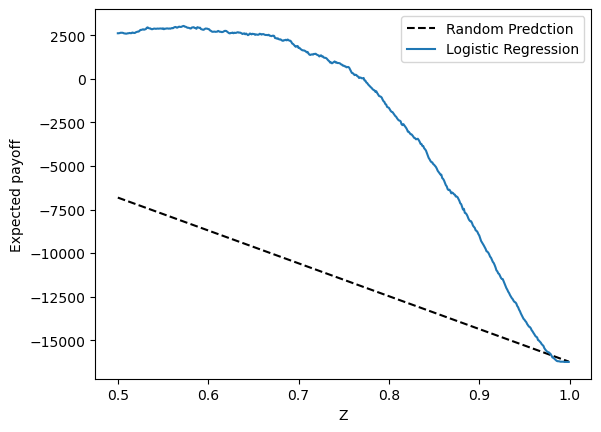

-------------
The optimal Z is:  0.5730000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  3040.3011048451854
   The confusion matrix under the optimal Z is: 
[[2355  166]
 [ 603  176]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.766969696969697  TPR: 0.9341531138437128  FPR: 0.7740693196405648
-------------
0.5730000000000001


In [280]:
# Plot the expected payoff curve of the logistic regression model and print 'z_optimal', 
# both based on the validation data

print(EP_curve(model, 'validate'))


### 2.3 Performance evaluation

#### 2.3.1  The performance of the logistic regression as a classifier
*  (Possibly building on the lecture codes) Report the MLE loss function values on training, validation, and test datasets

In [281]:
def loss_evaluation (reg_model):
    
    # y_train_pred, y_val_pred, and y_test_pred are the predicted probabilities for the training set
    # validation set and test set using the fitted logistic regression model

    y_train_pred= reg_model.predict_proba(X_train)
    y_val_pred= reg_model.predict_proba(X_val)
    y_test_pred= reg_model.predict_proba(X_test)

    # Calculate maximum likelihood for training set, validation set, and test set

    ##############
    #### This step calculates the log likelihood vectors (i.e., a vector that contains 
    #### the log likelihood value for each borrower), 
    #### one for each of training, validation, and test, respectively
    #### Some contents are left empty on purpose. Fill free to inject additional codes if needed.
    ##############

    ll_vector_train = np.log(y_train_pred)
    ll_vector_val = np.log(y_val_pred)
    ll_vector_test = np.log(y_test_pred)

    ###############

    # Calculate cost functions from maximum likelihoods

    loss_function_training = np.negative(np.sum(ll_vector_train)/len(y_train))
    loss_function_val = np.negative(np.sum(ll_vector_val)/len(y_val))
    loss_function_test = np.negative(np.sum(ll_vector_test)/len(y_test))
    
    return loss_function_training, loss_function_val, loss_function_test




In [282]:
# Print the MLE loss function values on training, validation, and test datasets
temp = loss_evaluation(model)
temp1 = ['Train', 'Validation', 'Test']

for i in range(len(temp)):
    print('{} loss: {}'.format(temp1[i], temp[i]))


Train loss: 2.0137062386617854
Validation loss: 2.010543030283562
Test loss: 2.0143210047358733


* (Possibly building on the lecture codes) Report the AUC score for the logistic regression classifier  (based on the **test** data).

In [283]:
# You can directly use the functions below (if needed)

def get_AUC (reg_model, evaluate_on = 'test'):
    
    ###########
    # Plot the ROC curve of a given classifier and the data to evaluate on. Also, calculate the AUC measure.
    # Input: reg_model is a sklearn classifier 
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is evaluated on the
    #        validation data or test data. By default, the ROC curve is evaluated on the test data.
    # Output: The AUC measure. Also, plot the curve.
    ###########
    
    # Get the appropriate feature and outcome data    
    X,y, _ = get_data (evaluate_on)
    
    # Get the predicted probablities from the current model and from random predictions
    model_prob = reg_model.predict_proba(X)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y))]
    
    # Get the AUC scores
    ns_auc=roc_auc_score(y, ns_prob)
    model_auc = roc_auc_score(y,model_prob)
    
    
    return model_auc


In [284]:
# Print the AUC measure of the logistic regression on the test data

print(get_AUC(model))


0.682665726421872


#### 2.3.1  The performance of the loan acceptance rule

Let us consider the loan acceptance rule determined by the logistic regression classifier with the threshold `z_optimal`. The evaluation should be based on the **test** data

* Evaluate and print the confusion matrix 

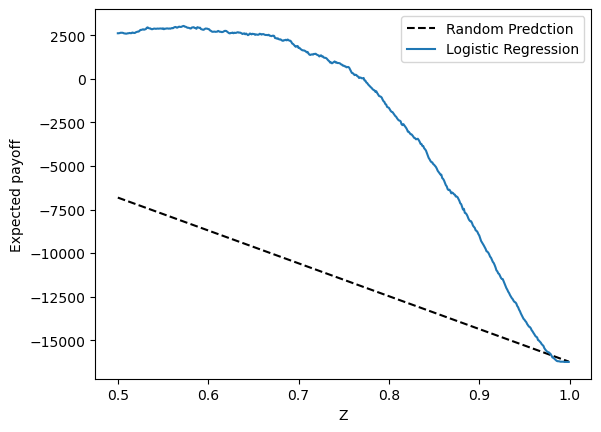

-------------
The optimal Z is:  0.5730000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  3040.3011048451854
   The confusion matrix under the optimal Z is: 
[[2355  166]
 [ 603  176]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.766969696969697  TPR: 0.9341531138437128  FPR: 0.7740693196405648
-------------
[[1878  156]
 [ 464  130]]


In [285]:
# Evaluate and print the confusion matrix (based on the test data)
z_optimal = EP_curve(model, 'validate')
print(get_cm(z_optimal, model, 'test'))


* Evaluate the expected payoff of the loan based on the average interest rates and loan amounts

In [286]:
# Evaluate the expected payoff of the loan based on the average interest rates and loan amounts in the test data

print(get_EP(z_optimal, model, 'test'))


2564.621283357974


# Part 3. Improving the Prediction using Regularization

Let us use L1 regularization to improve the prediction model and ultimately, the loan acceptance decision. 

* Let the regularization parameter Lambda range from 5 to 145. For each lambda, fit a logistic regression with L1 regularization. Plot three curves to answer the following three questions:
  * (1) How does the number of non-zero coefficients change with respect to lambda?
  * (2) How does the MLE loss function value change with respect to lambda for the training, validation, and test data, respectively? (You can plot three curves on the same graph)
  * (3) How does the AUC score change with respect to lambda for the validation and test, respectively? (You can plot two curves on the same graph)
  

  
* The training parameters we use are: 
   * `penalty="l1"` (It means we use L1 regularization) 
   *  `solver="liblinear"` (It means we use the liblinear method as the solver, which is slightly more specialized to the training problem with L1 regularization)


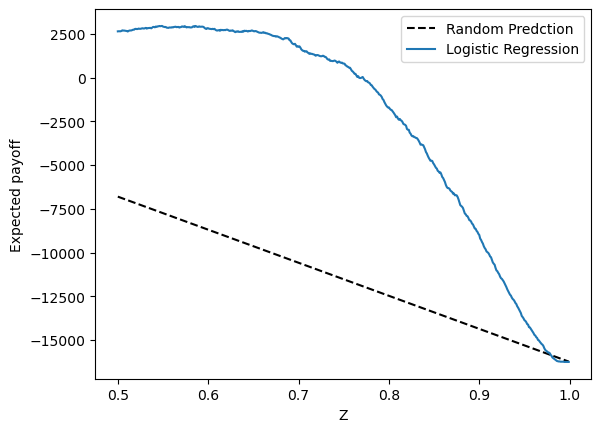

-------------
The optimal Z is:  0.549
Evaluated on: the validate data set
   The maximual expected payoff is:  2956.9949697267707
   The confusion matrix under the optimal Z is: 
[[2387  134]
 [ 630  149]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7684848484848484  TPR: 0.9468464894882983  FPR: 0.8087291399229781
-------------


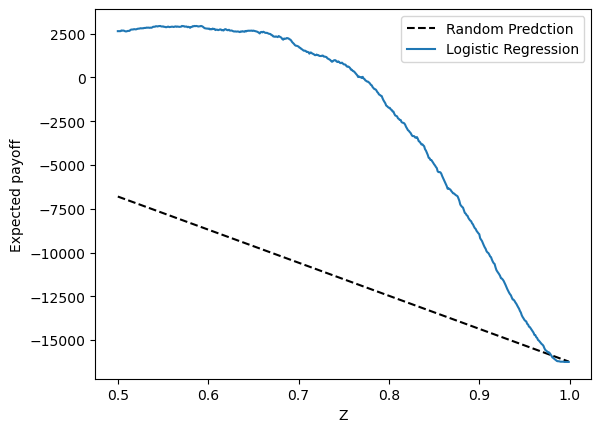

-------------
The optimal Z is:  0.5850000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2943.7403950953076
   The confusion matrix under the optimal Z is: 
[[2329  192]
 [ 590  189]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7630303030303031  TPR: 0.9238397461324871  FPR: 0.7573812580231065
-------------


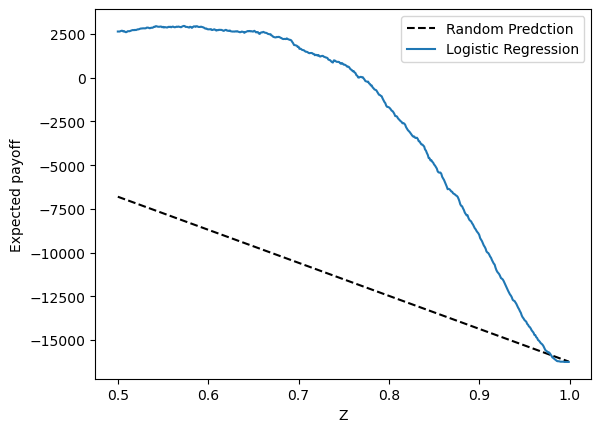

-------------
The optimal Z is:  0.5730000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2964.839002714038
   The confusion matrix under the optimal Z is: 
[[2352  169]
 [ 605  174]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7654545454545455  TPR: 0.9329631098770329  FPR: 0.7766367137355584
-------------


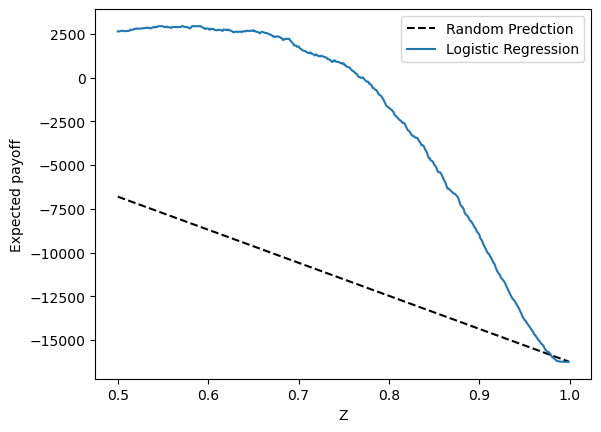

-------------
The optimal Z is:  0.5910000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2954.305755194051
   The confusion matrix under the optimal Z is: 
[[2317  204]
 [ 581  198]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7621212121212121  TPR: 0.9190797302657675  FPR: 0.7458279845956355
-------------


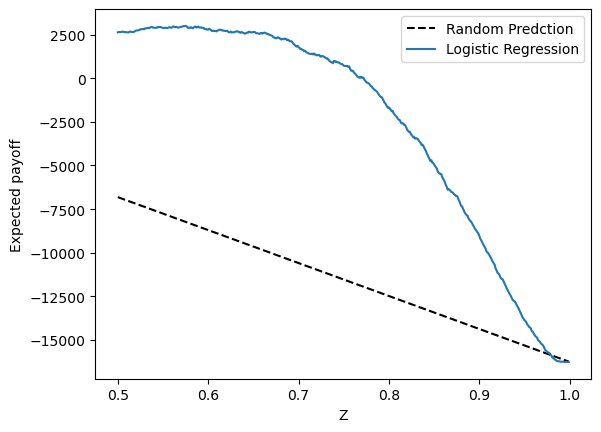

-------------
The optimal Z is:  0.5750000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2994.1658168247122
   The confusion matrix under the optimal Z is: 
[[2350  171]
 [ 602  177]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7657575757575757  TPR: 0.9321697738992464  FPR: 0.772785622593068
-------------


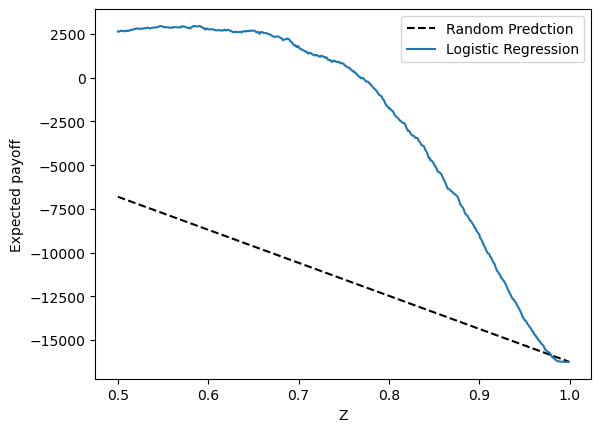

-------------
The optimal Z is:  0.5850000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2962.1176756025625
   The confusion matrix under the optimal Z is: 
[[2329  192]
 [ 589  190]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7633333333333333  TPR: 0.9238397461324871  FPR: 0.7560975609756098
-------------


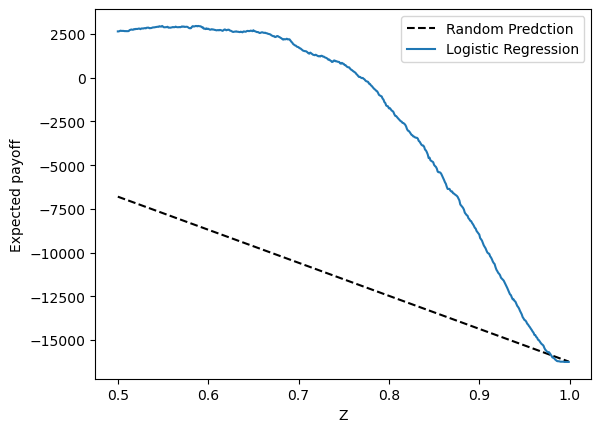

-------------
The optimal Z is:  0.5890000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2958.211715398307
   The confusion matrix under the optimal Z is: 
[[2323  198]
 [ 585  194]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7627272727272727  TPR: 0.9214597381991273  FPR: 0.7509627727856226
-------------


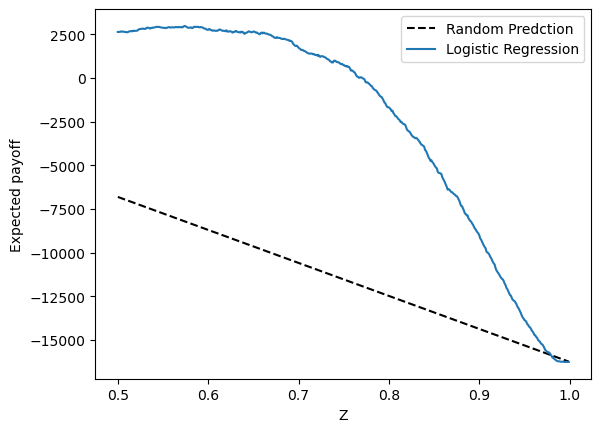

-------------
The optimal Z is:  0.5740000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2988.6910500230033
   The confusion matrix under the optimal Z is: 
[[2351  170]
 [ 603  176]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7657575757575757  TPR: 0.9325664418881396  FPR: 0.7740693196405648
-------------


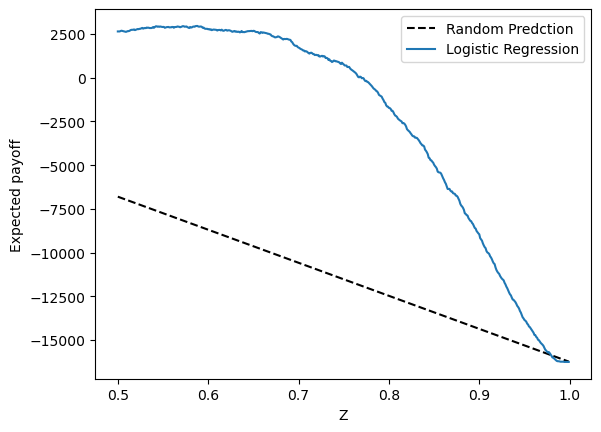

-------------
The optimal Z is:  0.5880000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2960.164695500435
   The confusion matrix under the optimal Z is: 
[[2326  195]
 [ 587  192]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7630303030303031  TPR: 0.9226497421658072  FPR: 0.7535301668806161
-------------


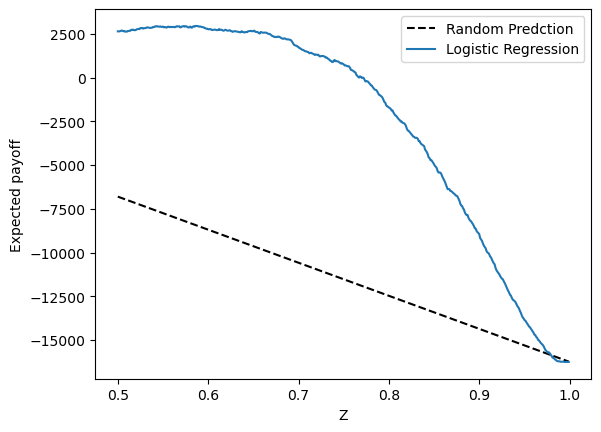

-------------
The optimal Z is:  0.5870000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2954.6899286987264
   The confusion matrix under the optimal Z is: 
[[2327  194]
 [ 588  191]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7630303030303031  TPR: 0.9230464101547006  FPR: 0.754813863928113
-------------


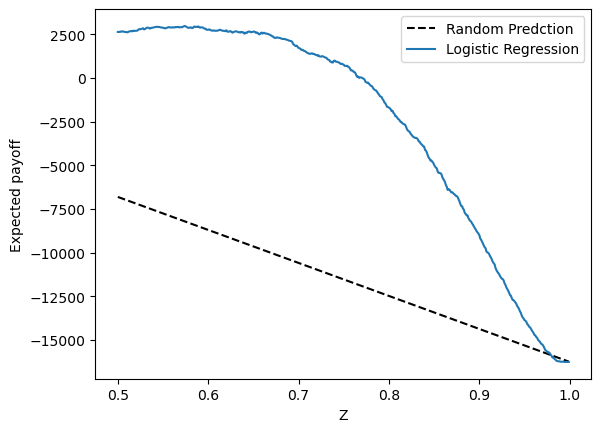

-------------
The optimal Z is:  0.5740000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2988.6910500230033
   The confusion matrix under the optimal Z is: 
[[2351  170]
 [ 603  176]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7657575757575757  TPR: 0.9325664418881396  FPR: 0.7740693196405648
-------------


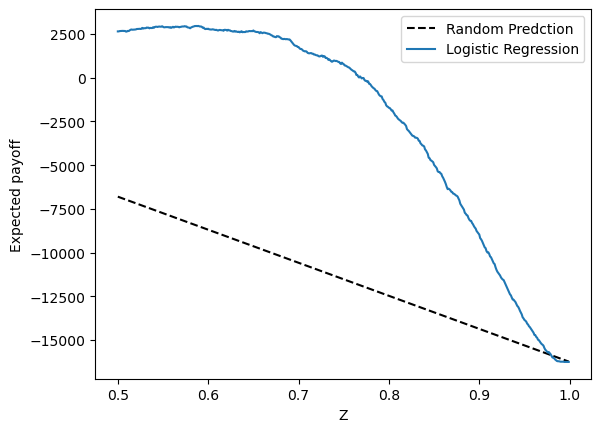

-------------
The optimal Z is:  0.5890000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2958.211715398307
   The confusion matrix under the optimal Z is: 
[[2323  198]
 [ 585  194]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7627272727272727  TPR: 0.9214597381991273  FPR: 0.7509627727856226
-------------


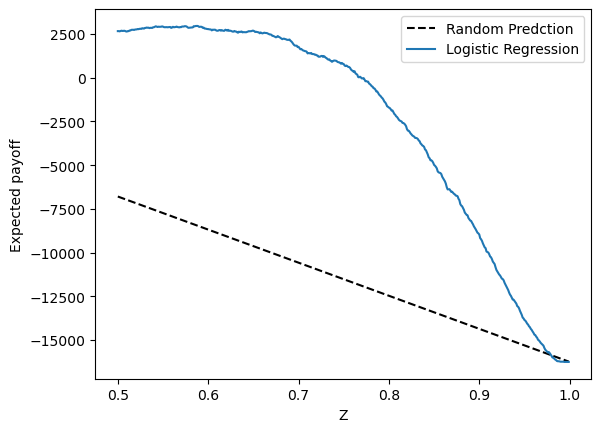

-------------
The optimal Z is:  0.5880000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2960.164695500435
   The confusion matrix under the optimal Z is: 
[[2326  195]
 [ 587  192]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7630303030303031  TPR: 0.9226497421658072  FPR: 0.7535301668806161
-------------


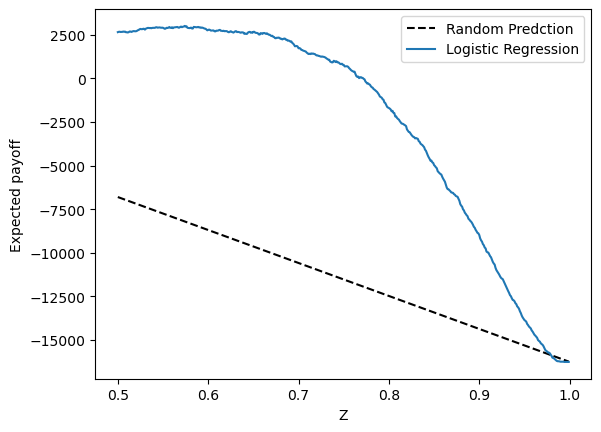

-------------
The optimal Z is:  0.5740000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  3001.593563728548
   The confusion matrix under the optimal Z is: 
[[2352  169]
 [ 603  176]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7660606060606061  TPR: 0.9329631098770329  FPR: 0.7740693196405648
-------------


In [287]:
# Let the regularization parameter Lambda range from 5 to 145. (We use LAMBDA to store its range.) 
# For each lambda, fit a logistic regression with L1 regularization. 
# Plot three curves to answer the following three questions:
# (1) How does the number of non-zero coefficients change with respect to lambda?
# (2) How does the MLE loss function value change with respect to lambda for the training, validation, and test data, respectively? (You can plot three curves on the same graph)
# (3) How does the AUC score change with respect to lambda for the validation and test, respectively? (You can plot two curves on the same graph)

# The range of lambda values
LAMBDA = np.arange(5,145, 10) 


for i in LAMBDA:
    L1_logreg_model = LogisticRegression(penalty='l1', solver='liblinear', C=i)
    L1_logreg_model.fit(X_train, y_train)
    EP_curve(L1_logreg_model, 'validate')


,lambda,non-zero
0,5,118
1,15,119
2,25,119
3,35,119
4,45,121
5,55,120
6,65,120
7,75,120
8,85,122
9,95,122


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_32796\1470100007.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  fig = sns.lineplot(x=plotting1['lambda'], y=plotting1['non-zero'], ci=None, color='#767676')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


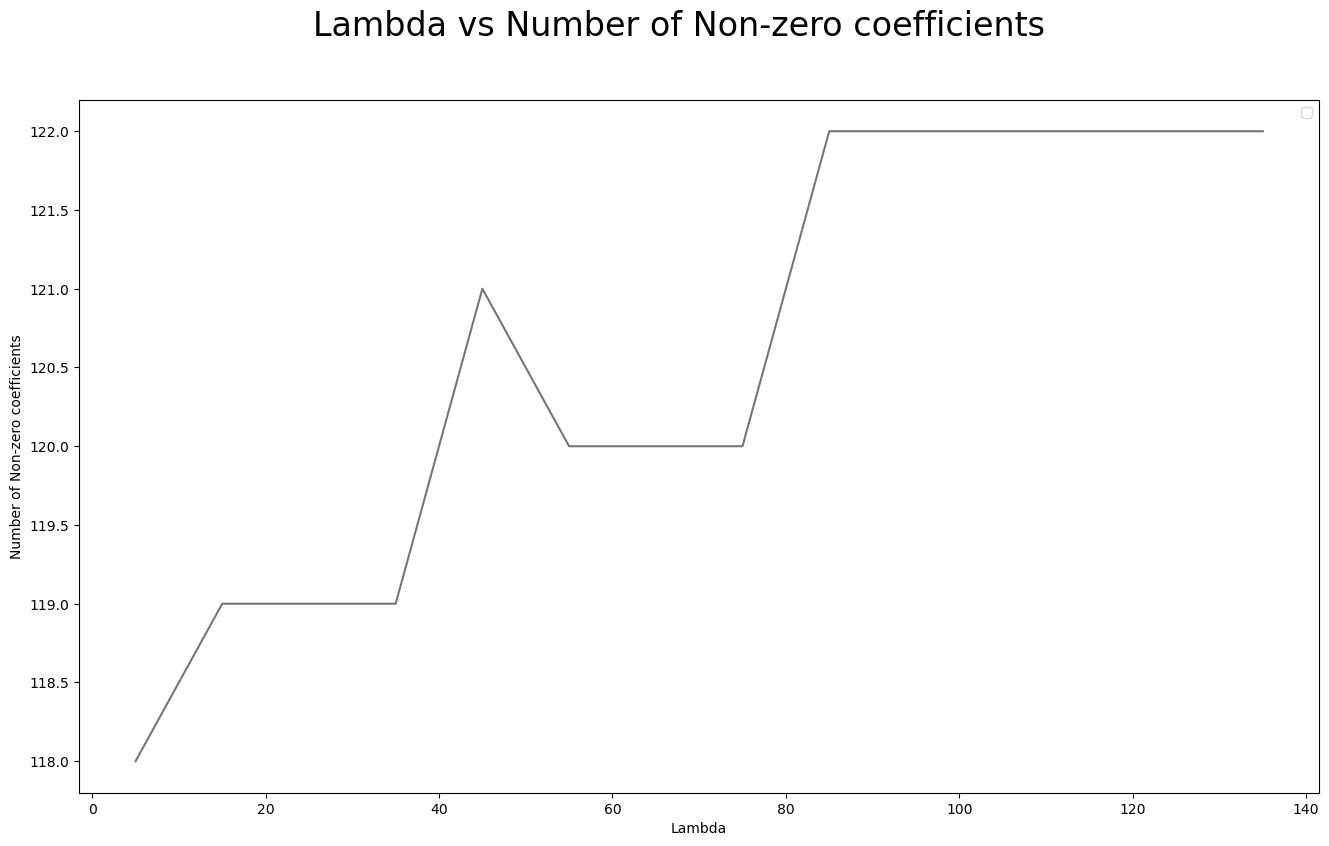

In [288]:
# Plot the number of non-zero coefficients for the l1-regularized logistic regression as lambda changes
temp = list()
for i in LAMBDA:
    L1_logreg_model = LogisticRegression(penalty='l1', solver='liblinear', C=i)
    L1_logreg_model.fit(X_train, y_train)
    temp.append(np.count_nonzero(L1_logreg_model.coef_))

plotting1 = pd.DataFrame(data={'lambda':LAMBDA, 'non-zero':temp})
display(plotting1)

#--------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(16,9))
fig = sns.lineplot(x=plotting1['lambda'], y=plotting1['non-zero'], ci=None, color='#767676')
plt.legend()
fig.set(xlabel='Lambda', ylabel='Number of Non-zero coefficients')
plt.suptitle('Lambda vs Number of Non-zero coefficients', fontsize = 24)
#plt.savefig('temp.png', transparent=True, dpi=600)
plt.show()


,lambda,train_prob,validation_prob,test_prob
0,5,0.473515,0.500383,0.498496
1,15,0.473512,0.500563,0.498706
2,25,0.473511,0.500725,0.498831
3,35,0.473511,0.500979,0.499002
4,45,0.473511,0.500511,0.498700
5,55,0.473511,0.500621,0.498751
6,65,0.473511,0.500658,0.498786
7,75,0.473511,0.500785,0.498898
8,85,0.473511,0.500768,0.498918
9,95,0.473511,0.500464,0.498667


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_32796\3872400061.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  fig = sns.lineplot(x=plotting2['lambda'], y=plotting2['train_prob'], ci=None, color='#767676')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_32796\3872400061.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  fig = sns.lineplot(x=plotting2['lambda'], y=plotting2['validation_prob'], ci=None, color='#3f7f93')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_32796\3872400061.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  fig = sns.lineplot(x=plotting2['lambda'], y=plotting2['test_prob'], ci=None, color='#edb021')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


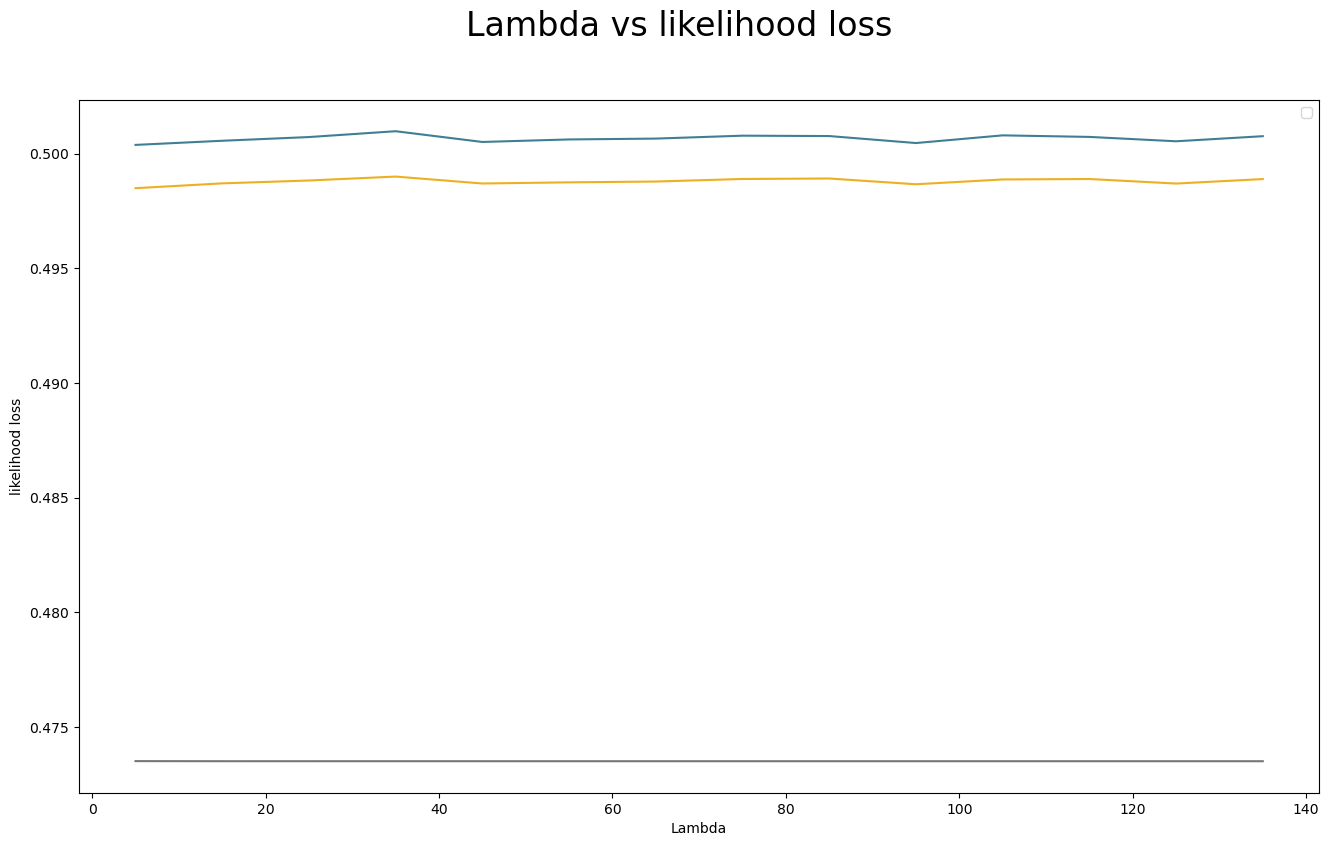

In [289]:
# Plot the likelihood loss function values (on training, validation, and test data sets) 
# for the l1-regularized logistic regression as lambda changes
# y axis is likelihood loss function 

train_prob = list()
val_prob = list()
test_prob = list()


for i in LAMBDA:
    L1_logreg_model = LogisticRegression(penalty='l1', solver='liblinear', C=i)
    L1_logreg_model.fit(X_train, y_train)
    train_prob.append(log_loss(y_train, L1_logreg_model.predict_proba(X_train)))
    val_prob.append(log_loss(y_val, L1_logreg_model.predict_proba(X_val)))
    test_prob.append(log_loss(y_test, L1_logreg_model.predict_proba(X_test)))

plotting2 = pd.DataFrame(data={'lambda':LAMBDA,
                               'train_prob':train_prob,
                               'validation_prob':val_prob,
                               'test_prob':test_prob
                              })
display(plotting2)

#--------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(16,9))
fig = sns.lineplot(x=plotting2['lambda'], y=plotting2['train_prob'], ci=None, color='#767676')
fig = sns.lineplot(x=plotting2['lambda'], y=plotting2['validation_prob'], ci=None, color='#3f7f93')
fig = sns.lineplot(x=plotting2['lambda'], y=plotting2['test_prob'], ci=None, color='#edb021')



plt.legend()
fig.set(xlabel='Lambda', ylabel='likelihood loss')
plt.suptitle('Lambda vs likelihood loss', fontsize = 24)
#plt.savefig('temp.png', transparent=True, dpi=600)
plt.show()


,lambda,auc
0,5,0.683719
1,15,0.683398
2,25,0.683308
3,35,0.683242
4,45,0.683398
5,55,0.683132
6,65,0.682923
7,75,0.683387
8,85,0.683091
9,95,0.683123


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


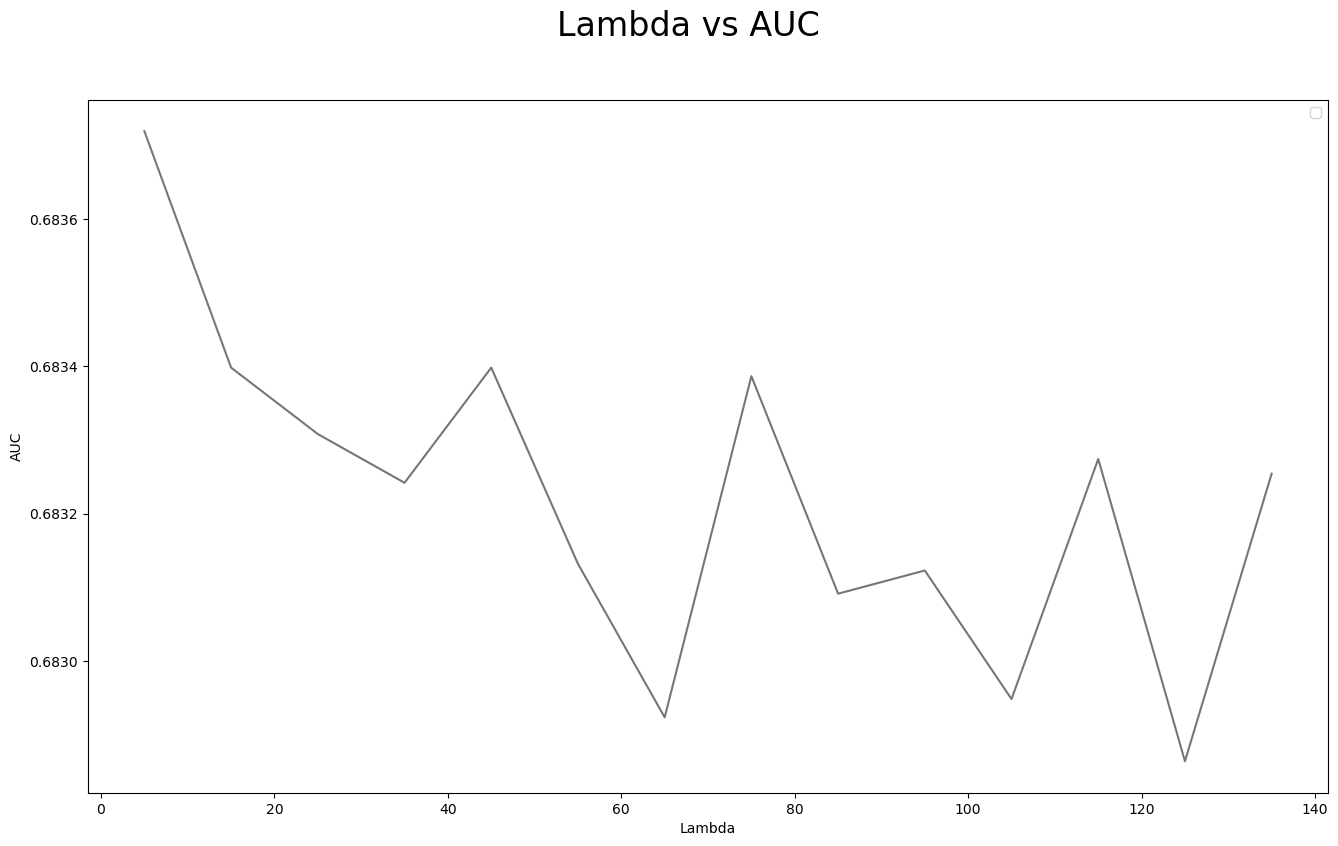

In [295]:
# Plot the AUC measures for the l1-regularized logistic regression as lambda changes

auc_lst = list()

for i in LAMBDA:
    L1_logreg_model = LogisticRegression(penalty='l1', solver='liblinear', C=i)
    L1_logreg_model.fit(X_train, y_train)
    auc_lst.append(get_AUC(L1_logreg_model))

plotting3 = pd.DataFrame(data={'lambda':LAMBDA, 'auc':auc_lst})
display(plotting3)

#--------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(16,9))
fig = sns.lineplot(x=plotting3['lambda'], y=plotting3['auc'], errorbar=None, color='#767676')




plt.legend()
fig.set(xlabel='Lambda', ylabel='AUC')
plt.suptitle('Lambda vs AUC', fontsize = 24)
#plt.savefig('temp.png', transparent=True, dpi=600)
plt.show()





* Suppose somebody has determined that the optimal regularization parameter is `lambda_optimal` = 40. What is the optimal threshold Z that obtains the highest expected payoff on the **validation** set? 

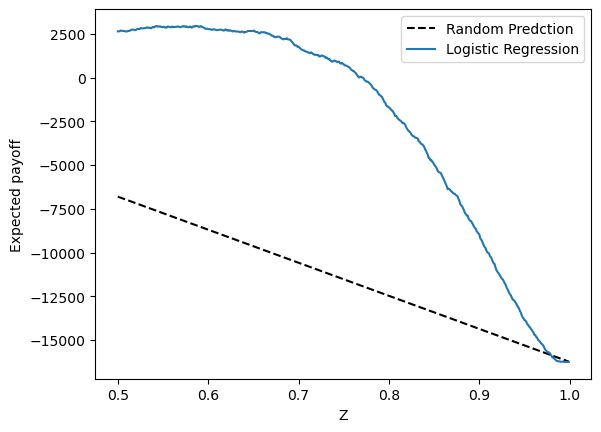

-------------
The optimal Z is:  0.5870000000000001
Evaluated on: the validate data set
   The maximual expected payoff is:  2954.6899286987264
   The confusion matrix under the optimal Z is: 
[[2327  194]
 [ 588  191]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.7630303030303031  TPR: 0.9230464101547006  FPR: 0.754813863928113
-------------
0.5870000000000001


In [297]:
# Suppose somebody has determined that the optimal regularization parameter is lambda_optimal = 40. 
lambda_optimal = 40


# What is the optimal threshold Z that obtains the highest expected payoff on the validation set? 
# Save it in the variable 'z_optimal_l1' and print its value

L1_logreg_model = LogisticRegression(penalty='l1', solver='liblinear', C=lambda_optimal)
L1_logreg_model.fit(X_train, y_train)
z_optimal_l1 = EP_curve(L1_logreg_model, 'validate')
print(z_optimal_l1)

* Evaluate the prediction model on the **test** data set using the following metrics:
   * AUC score of the classifier
   * Confusion matrix (given the previously chosen threshold)
   * Expected payoff (given the previously chosen threshold)

In [301]:
# Evaluate the prediction model on the test data using the following metrics:
# (1) AUC score of the classifier
# (2) Confusion matrix (given the previously chosen threshold 'z_optimal_l1')
# (3) Expected payoff (given the previously chosen threshold 'z_optimal_l1')


# Print the AUC score of the regualized logistics classifier on the test data
print(get_AUC(L1_logreg_model, 'test'))


# Print the confusion matrix of the regualized logistics classifier on the test data (given the previously chosen threshold 'z_optimal_l1')
print(get_cm(z_optimal_l1, L1_logreg_model, 'test'))



# print the expected payoff on the test data (given the previously chosen threshold 'z_optimal_l1')
print(get_EP(z_optimal_l1, L1_logreg_model, 'test'))


0.683310489357687
[[1861  173]
 [ 447  147]]
2702.2763426556776
